<a href="https://colab.research.google.com/github/aMurryFly/1_semestre/blob/master/FinalProject_TwittClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project of APIT Course
## Data Analysis and Text Classification AI Model on COVID-19 Tweets

###(Análisis y Procesamiento Inteligente de textos)

**Professor:**
- Octavio Augusto Sánchez Velázquez

**Students:**
- Alfonso Murrieta Villegas
- Edgar Michael Pérez Valdez


# 0. Aspectos generales 


## 0.0 Importación de bibliotecas y recursos para el análisis de datos en la etapa de pre-procesamiento

In [1]:
#Bibliotecas generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.style.use('ggplot')

# Para la construcción del módelo
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats


In [2]:
# Azúcar visual 
import warnings
warnings.filterwarnings('ignore')

#Para dar formato a los dataframes
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## 0.1 Importando  y conociendo el dataset

### 0.1.0 Importando datos 

In [3]:
test=pd.read_csv("/content/DataSet/Corona_NLP_test.csv",encoding='latin1')
train=pd.read_csv("/content/DataSet/Corona_NLP_train.csv",encoding='latin1')

Conociendo nuestros datos para el "test" del futuro módelo

In [4]:
test.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [5]:
test.shape[0]

3798

Conociendo nuestros datos para el "train" del futuro módelo

In [6]:
train.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
train.shape[0]

41157

### 0.1.1 Relación Train y Test Data

Observando relación del dataset de "train y test"

**NOTA**: Para nuestra futura construcción del modelo de AI emplearemos una relación de 75 / 25 como típica convención 

In [8]:
totalData = train.shape[0] + test.shape[0]
print("Total de datos (filas)", totalData)
print("Relación del train respecto al total: ",train.shape[0]/totalData)
print("Relación del test respecto al total: ",test.shape[0]/totalData)

Total de datos (filas) 44955
Relación del train respecto al total:  0.9155155155155155
Relación del test respecto al total:  0.08448448448448448


### 0.1.2 Valores Nulos

Conociendo valores nulos en el dataset

NOTA: Se unieron los datos previamente para conocer la información global

In [9]:
concData=pd.concat([train,test])

nullValues= concData.isnull().sum().sort_values(ascending=False)
total =concData.shape[0]

percent_missing= (concData.isnull().sum()/total).sort_values(ascending=False)
loss_data= pd.concat([nullValues, percent_missing], axis=1, keys=['Datos nulos', 'Porcetaje'])

Imprimimos los datos obtenidos tras la concatenación de ambos dataframes

In [10]:
print (loss_data)

               Datos nulos  Porcetaje
Location              9424   0.209632
Sentiment                0   0.000000
OriginalTweet            0   0.000000
TweetAt                  0   0.000000
ScreenName               0   0.000000
UserName                 0   0.000000


**NOTA:** Podemos observar que hay una cantidad considerable de datos nulos en la columna de "location", sin embargo, para nuestro modelo no será necesaria esa información.

### 0.1.3 Relación tweets / usuarios 

Al tomar una muestra lo recomendable es no sesgar la información como puede ser el caso de recopilar la información de una misma fuente, es decir, hacer un muestreo aleatorio

Por lo que a continuación se verifica la realación tweets - usuarios (QUe tantos tweets pertenecen a un usuario)

In [11]:
print('Total de tweets: ', concData.shape[0])
print('Total de usuarios (Sin repetir alguno): ', concData['UserName'].nunique())

Total de tweets:  44955
Total de usuarios (Sin repetir alguno):  44955


**NOTA**: Podemos observar que no existe más de un tweet por usuario

# 1. Análisis de datos

**NOTA**

Para el análisis de datos y la construcción del modelo de AI de clasificación de Tweets fue necesario cambiar la cantidad de etiquetas dentro de la clasificación de tweets 

```python
['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
```
a

```python
['Neutral' 'Positive' 'Negative' ]
``` 
Donde los casos "extremos" fueron adjuntados en la etiqueta normal, es decir:

'Extremely Negative', 'Negative' => 'Negative'

'Extremely Positive', 'Positive' => 'Positive'

**Justificación:** 

La primera razón del por qué se hará esta recategorización en las etiquetas de sentimal es debido a la complejidad algoritmica y recursos empleados al usar 3 etiquetas en vez de 5.

Y la segunda razón es que encontramos algo subjetivo el decir que un tweet es "extremadamente positivo" o que solamente es "positivo". 


## 1.1 Reetiquetando

Muestreo de datos antes de reetiquetar los datos

In [12]:
print(concData.Sentiment.value_counts())

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


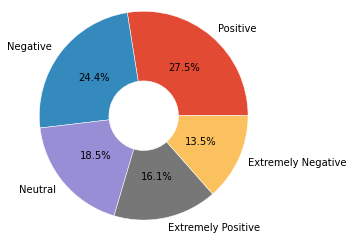

In [13]:
pre_class_allData = concData.groupby('Sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
percent_class= pre_class_allData.OriginalTweet
labels= pre_class_allData.Sentiment

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,autopct="%.1f%%")

plt.setp(my_pie, width=0.8, edgecolor='white') 

plt.show()

Reetiquetando datos

In [14]:
def reetiqueta(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"

In [15]:
dataFrame = concData 
dataFrame['sentiment']= concData['Sentiment'].apply(lambda x:reetiqueta(x))

print("Distribución previa:\n ", concData.Sentiment.value_counts())
print("\n\n\nDistribución actual: \n", dataFrame.sentiment.value_counts())

Distribución previa:
  Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64



Distribución actual: 
 positive    19592
negative    17031
neutral      8332
Name: sentiment, dtype: int64


Nueva distribución de los datos y visualización del nuevo dataFrame

In [16]:
dataFrame.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,negative


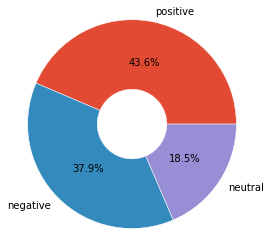

In [17]:
class_allData = dataFrame.groupby('sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
percent_class= class_allData.OriginalTweet
labels= class_allData.sentiment

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,autopct="%.1f%%")

plt.setp(my_pie, width=0.8, edgecolor='white') 

plt.show()

## 1.2 Distribución de datos 

### 1.2.1 Carácteres

Gráficas para conocer la distribución dentro de cada clase en la etiqueta de sentimientos

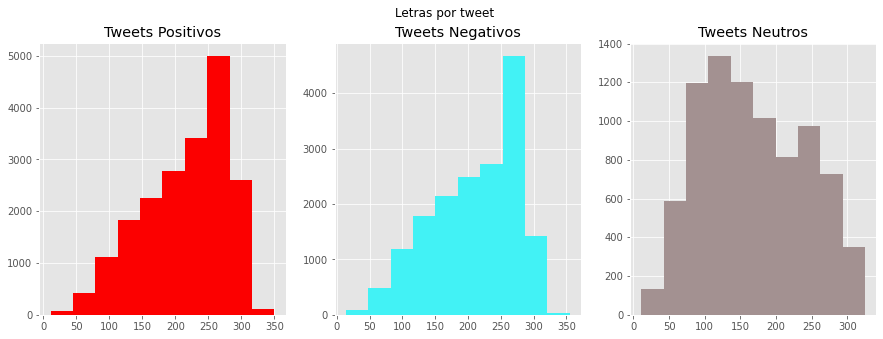

In [18]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_Pos=dataFrame[dataFrame['sentiment']=="positive"]['OriginalTweet'].str.len()
ax1.hist(tweet_Pos,color='#FC0000')
ax1.set_title('Tweets Positivos')

tweet_Neg=dataFrame[dataFrame['sentiment']=="negative"]['OriginalTweet'].str.len()
ax2.hist(tweet_Neg,color='#42F2F5')
ax2.set_title('Tweets Negativos')

tweet_Null=dataFrame[dataFrame['sentiment']=="neutral"]['OriginalTweet'].str.len()
ax3.hist(tweet_Null,color='#A39191')
ax3.set_title('Tweets Neutros')

fig.suptitle('Letras por tweet')
plt.show()

In [19]:
# Agregando header para medias
#Solo correr una vez
tweet_Pos = tweet_Pos.to_frame('characters') 
tweet_Neg = tweet_Neg.to_frame('characters') 
tweet_Null = tweet_Null.to_frame('characters') 

In [20]:

PosMedia = tweet_Pos['characters'].mean()
NegMedia = tweet_Neg['characters'].mean()
NullMedia = tweet_Null['characters'].mean()

print("Promedio de carácteres en tweets positivos",PosMedia )
print("Promedio de carácteres en tweets negativos",NegMedia )
print("Promedio de caracteres en tweets nulos",NullMedia )

Promedio de carácteres en tweets positivos 215.60090853409554
Promedio de carácteres en tweets negativos 210.87358346544536
Promedio de caracteres en tweets nulos 168.16082573211713


**NOTA:**
Podemos observar a priori que notamos ciertos patrones de asimetría en las respectivas distribuciones sin embargo observamos 

### 1.2.2 Distribución y promedio de palabras 


(0.0, 20.0)

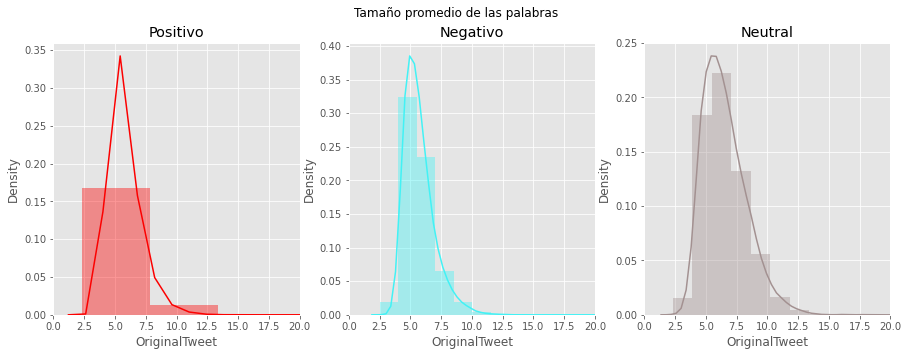

In [21]:
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(15,5))
fig.suptitle('Tamaño promedio de las palabras \n')

Pos_words=dataFrame[dataFrame['sentiment']=="positive"]['OriginalTweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(Pos_words.map(lambda x: np.mean(x)),ax=ax1,color='#FC0000')
ax1.set_title('Positivo')
ax1.set_xlim(0,20)

Neg_word=dataFrame[dataFrame['sentiment']=="negative"]['OriginalTweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(Neg_word.map(lambda x: np.mean(x)),ax=ax2,color='#42F2F5')
ax2.set_title('Negativo')
ax2.set_xlim(0,20)

Null_word=dataFrame[dataFrame['sentiment']=="neutral"]['OriginalTweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(Null_word.map(lambda x: np.mean(x)),ax=ax3,color='#A39191')
ax3.set_title('Neutral')
ax3.set_xlim(0,20)

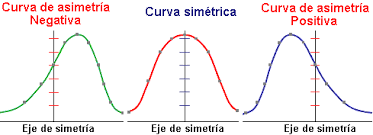

# 2. Contruyendo el modelo de IA para clasificar
 